<a href="https://colab.research.google.com/github/ShahZebYousafzai/Deep-Learning-Basics/blob/main/6_Transfer_Learning(FineTuning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer_Learning (FineTuning)

In previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [1]:
# Check if we're using a GPU
!nvidia-smi

Tue Oct 19 14:34:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-19 14:34:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-19 14:34:24 (82.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_function.py`, so you'll have to redownload it if you want access to your helper_functions.

## Let's get some data

This time we're going to see how we can use the pretrained models with `tf.keras.applications` and apply them to our own problem (recognizing images of food.

In [4]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-10-19 14:34:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.206.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   128MB/s    in 1.3s    

2021-10-19 14:34:29 (128 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Cehck out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create Train and test directory paths
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for image, label in train_data_10_percent.take(1):
  print(image, label)

tf.Tensor(
[[[[2.53000000e+02 2.55000000e+02 2.50459183e+02]
   [2.53000000e+02 2.55000000e+02 2.50091827e+02]
   [2.53000000e+02 2.55000000e+02 2.50275513e+02]
   ...
   [2.53000000e+02 2.55000000e+02 2.52000000e+02]
   [2.53000000e+02 2.55000000e+02 2.52000000e+02]
   [2.53000000e+02 2.55000000e+02 2.52000000e+02]]

  [[2.54000000e+02 2.54000000e+02 2.54239807e+02]
   [2.54000000e+02 2.54000000e+02 2.53933670e+02]
   [2.54000000e+02 2.54000000e+02 2.54086731e+02]
   ...
   [2.54000000e+02 2.54000000e+02 2.52000000e+02]
   [2.54000000e+02 2.54000000e+02 2.52000000e+02]
   [2.54000000e+02 2.54000000e+02 2.52000000e+02]]

  [[2.54000000e+02 2.53214279e+02 2.55000000e+02]
   [2.54000000e+02 2.53214279e+02 2.55000000e+02]
   [2.54000000e+02 2.53214279e+02 2.55000000e+02]
   ...
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]]

  ...

  [[2.54142883e+02 2.54642853e+02 2.50428528e+02]
   [2

In this notebook, we will be doing a lot of experiments. These are mentioned below.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-qxxr{background-color:#FFF;border-color:inherit;font-size:16px;text-align:center;vertical-align:top}
.tg .tg-bn4o{font-size:18px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-qv16{font-size:16px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-gmla{border-color:inherit;font-size:16px;text-align:center;vertical-align:top}
.tg .tg-a41q{background-color:#FFF;border-color:inherit;font-size:18px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-2xbj{border-color:inherit;font-size:18px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-lvth{font-size:16px;text-align:center;vertical-align:top}
.tg .tg-rwiu{background-color:#FFF;font-size:16px;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-a41q">Experiment</th>
    <th class="tg-a41q">Data</th>
    <th class="tg-2xbj">Preprocessing</th>
    <th class="tg-bn4o">Model</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-qxxr">Model 0 (baseline)</td>
    <td class="tg-qxxr">10 classes of Food101 (<span style="font-weight:bold">random 10%</span><br><span style="font-weight:normal">training data only)</span></td>
    <td class="tg-gmla">None</td>
    <td class="tg-lvth"><span style="font-weight:bold">Feature Extractor: </span>EfficientNetB0<br>(pre-trained on ImageNet, all layers<br>frozen) with no top</td>
  </tr>
  <tr>
    <td class="tg-gmla">Model 1</td>
    <td class="tg-qxxr">10 classes of Food101 (<span style="font-weight:bold">random 1%</span><br><span style="font-weight:normal">training data only)</span></td>
    <td class="tg-gmla">Random Flip, Rotation,<br>Zoom, Height, Width,<br>data augmentation</td>
    <td class="tg-lvth">Same as Model 0</td>
  </tr>
  <tr>
    <td class="tg-qxxr">Model 2</td>
    <td class="tg-qxxr">Same as Model 0</td>
    <td class="tg-gmla">Same as Model 1</td>
    <td class="tg-lvth">Same as Model 0</td>
  </tr>
  <tr>
    <td class="tg-rwiu">Model 3</td>
    <td class="tg-lvth">Same as Model 0</td>
    <td class="tg-lvth">Same as Model 1</td>
    <td class="tg-qv16">Fine Tuning: <span style="font-weight:normal">Model 2 (EfficientNetB0</span><br><span style="font-weight:normal">pre-trained on ImageNet) </span><span style="font-weight:bold">with top</span><br><span style="font-weight:bold">layer trained on custom data, top 10</span><br><span style="font-weight:bold">layers unfrozen </span></td>
  </tr>
  <tr>
    <td class="tg-rwiu">Model 4</td>
    <td class="tg-lvth">10 classes of Food101 data (<span style="font-weight:bold">100%</span><span style="font-weight:normal"> training</span><br><span style="font-weight:normal">data)</span></td>
    <td class="tg-lvth">Same as Model 1</td>
    <td class="tg-lvth">Same as Model 3</td>
  </tr>
</tbody>
</table>

In previous notebooks, we used a lot of Keras's **[Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)**. But this time we will be using **[Functional API](https://www.tensorflow.org/guide/keras/functional)** which is more flexible and able to produce more sophisticated models.

> 🔑 **Note:** The compiling, fitting and evaluation method for Functional API is the same as Sequential API.

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [11]:
# 1. Create the base model with tf.keras.model.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)  # We don't want to include to top layer b/c we want to add
                                                                      # our own dense layer for output layer

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20211019-143441
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 47s 475ms/step - loss: 1.9678 - accuracy: 0.3373 - val_loss: 1.3507 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - 9s 360ms/step - loss: 1.1725 - accuracy: 0.7267 - val_loss: 0.9013 - val_accuracy: 0.8059
Epoch 3/5
24/24 [==============================] - 7s 269ms/step - loss: 0.8494 - accuracy: 0.8200 - val_loss: 0.7169 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - 7s 267ms/step - loss: 0.6978 - accuracy: 0.8293 - val_loss: 0.6444 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 7s 265ms/step - loss: 0.5941 - accuracy: 0.8680 - val_loss: 0.5715 - val_accuracy: 0.8734


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 11s 136ms/step - loss: 0.6066 - accuracy: 0.8460


[0.6065710186958313, 0.8460000157356262]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [15]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


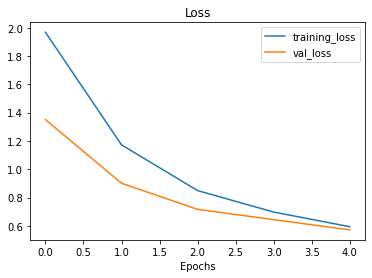

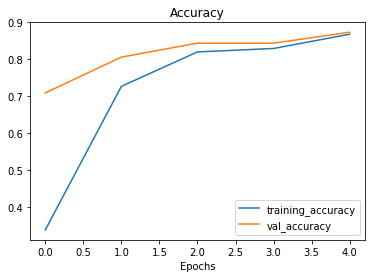

In [16]:
# Check out model's training curves
plot_loss_curves(history_10_percent)

Our model has given a good accuracy and if we train it for more epochs we might even get better accuracy.

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [17]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor shape:\n {input_tensor.shape}\n")
print(f"Random input tensor:\n {input_tensor}\n")

# Pass random tensor through AverageGlobalPooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Shape after AverageGlobalPooling2D:\n{global_average_pooled_tensor.shape}\n")
print(f"Tensors after AverageGlobalPooling2D:\n{global_average_pooled_tensor}\n")

Random input tensor shape:
 (1, 4, 4, 3)

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Shape after AverageGlobalPooling2D:
(1, 3)

Tensors after AverageGlobalPooling2D:
[[-0.09368646 -0.45840448 -0.2885598 ]]



What `GlobalAveragePooling2D` layer does is condenses it into scaller vector which is then the input to our final dense layer i.e. output layer.

In [18]:
# Let's replicate the GlobalAveragePool 2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

We've got the same results by using [`tf.reduce_mean`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean).

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is because what happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents  the learned representation of the model in a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out for our own specific problem. 

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with 10% of the training data, but how about we go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [19]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2021-10-19 14:36:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.13.128, 142.251.5.128, 74.125.206.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  98.8MB/s    in 1.3s    

2021-10-19 14:36:26 (98.8 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create training and test directories
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent  = "10_food_classes_1_percent/test"

In [21]:
# How many image we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'

In [22]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benifits of doing this within the TensorFlow Data Augmentation documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

Off the top of our heads, after reading the docs, the benifits of using data augmentation inside the model are:
* Preprocessing of image (aumenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere. But during inference (testing), augmenation does not happen.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms etc
data_augmentation = keras.Sequential([
                                     preprocessing.RandomFlip("horizontal"),
                                     preprocessing.RandomRotation(0.2),
                                     preprocessing.RandomZoom(0.2),
                                     preprocessing.RandomHeight(0.2),
                                     preprocessing.RandomWidth(0.2),
                                    #  preprocessing.Rescaling(1./255)  # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
], name="data_augmentation0")

### Visualize our data augmentation layer (see what happens to our data)

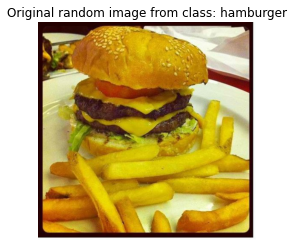

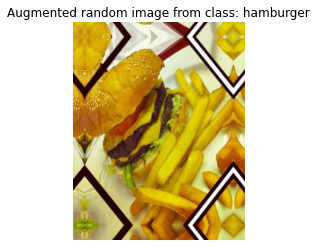

In [24]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented data
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature Extraction transfer learning on 1% of the data with augmentation

In [25]:
# Setup the input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_laerning/1_percent_data_aug/20211019-143632
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 17s 5s/step - loss: 2.4486 - accuracy: 0.0714 - val_loss: 2.2382 - val_accuracy: 0.1776
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1388 - accuracy: 0.2143 - val_loss: 2.1292 - val_accuracy: 0.2286
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9295 - accuracy: 0.4143 - val_loss: 2.0413 - val_accuracy: 0.3109
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7897 - accuracy: 0.5429 - val_loss: 1.9137 - val_accuracy: 0.3914
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6014 - accuracy: 0.6429 - val_loss: 1.8351 - val_accuracy: 0.4178


In [26]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation0 (Sequenti (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [27]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 131ms/step - loss: 1.8270 - accuracy: 0.4396


[1.8270357847213745, 0.43959999084472656]

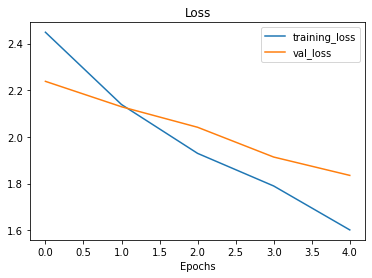

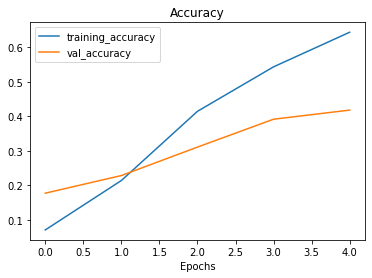

In [28]:
# How do the model with 1% of the data and dataaugmented data loss curve look like
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

In [29]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [30]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE=(224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
# How many images are in our directories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [32]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = keras.Sequential([
                                     preprocessing.RandomFlip("horizontal"),
                                     preprocessing.RandomRotation(0.2),
                                     preprocessing.RandomZoom(0.2),
                                     preprocessing.RandomHeight(0.2),
                                     preprocessing.RandomWidth(0.2),
                                    #  preprocessing.Rescaling(1./255)  # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and the outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images (audmentation does not occur on test data)
x = base_model(x, training=False) # pass the augmented image to the base model but keep base model in inference mode, this also insures batch_norm layers don't get updated
x = layers.GlobalAvgPool2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

### Creating a ModelCheckpoints callbacks

The [ModelCheckpoint callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) intermediately saves our model (the full model or just the weights) during training. This is useful so we cam come and start where we left off.

In [33]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that save the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # Save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [34]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=5,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20211019-143722
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 29s 907ms/step - loss: 2.0342 - accuracy: 0.3253 - val_loss: 1.5498 - val_accuracy: 0.6069

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 16s 648ms/step - loss: 1.3755 - accuracy: 0.6947 - val_loss: 1.0972 - val_accuracy: 0.7434

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 14s 549ms/step - loss: 1.0637 - accuracy: 0.7373 - val_loss: 0.9079 - val_accuracy: 0.7714

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 13s 511ms/step - loss: 0.8947 - accuracy: 0.7600 - val_loss: 0.7943 - val_accuracy: 0.7845

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 15s 601ms/step - loss: 0.7757 - accuracy: 0.8120 - val_

In [35]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.6066 - accuracy: 0.8460


[0.6065710186958313, 0.8460000157356262]

In [36]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 11s 131ms/step - loss: 0.6939 - accuracy: 0.8088


[0.6938950419425964, 0.8087999820709229]

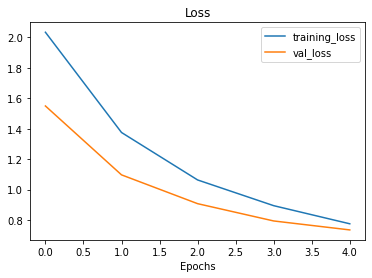

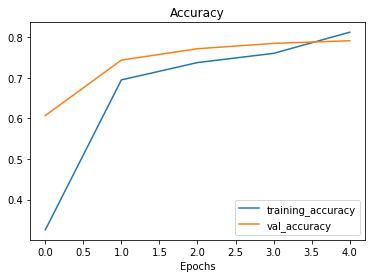

In [37]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in a checkpointed weights returns a model to a specific checkpoint

In [38]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [39]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.6939 - accuracy: 0.8088


In [40]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

Sometimes it's not True as value can be in different decimal points

In [41]:
results_10_percent_data_aug

[0.6938950419425964, 0.8087999820709229]

In [42]:
loaded_weights_model_results

[0.6938949227333069, 0.8087999820709229]

In [43]:
# Check to see if loaded model results are very close to native model results (should output True)
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [44]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [45]:
# Layers in loaded model
model_2.layers

In [46]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f8bf5709c50> True
<keras.engine.sequential.Sequential object at 0x7f8bf4927110> True
<keras.engine.functional.Functional object at 0x7f8bf5226ad0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f8bf5215550> True
<keras.layers.core.Dense object at 0x7f8bf524f510> True


In [47]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(layer.name, layer.trainable)

input_3 False
rescaling_2 False
normalization_2 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [48]:
# How many trainable variables are there in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [49]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),  # when fine-tuning you typically want to lower the learning by 10x
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


> 🔑 **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values.

📚 **Resource:** https://arxiv.org/abs/1801.06146

In [50]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [51]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [53]:
# Fine-tune for another epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20211019-144716
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 25s 699ms/step - loss: 0.6830 - accuracy: 0.8093 - val_loss: 0.5995 - val_accuracy: 0.8076
Epoch 6/10
24/24 [==============================] - 14s 566ms/step - loss: 0.5530 - accuracy: 0.8440 - val_loss: 0.5396 - val_accuracy: 0.8207
Epoch 7/10
24/24 [==============================] - 12s 490ms/step - loss: 0.4729 - accuracy: 0.8533 - val_loss: 0.4981 - val_accuracy: 0.8355
Epoch 8/10
24/24 [==============================] - 12s 467ms/step - loss: 0.4349 - accuracy: 0.8693 - val_loss: 0.5394 - val_accuracy: 0.8158
Epoch 9/10
24/24 [==============================] - 14s 585ms/step - loss: 0.3831 - accuracy: 0.8920 - val_loss: 0.5062 - val_accuracy: 0.8372
Epoch 10/10
24/24 [==============================] - 12s 503ms/step - loss: 0.3513 - accuracy: 0.9000 - val_loss: 0.5016 - val_accuracy: 0.8322


In [54]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.4822 - accuracy: 0.8336


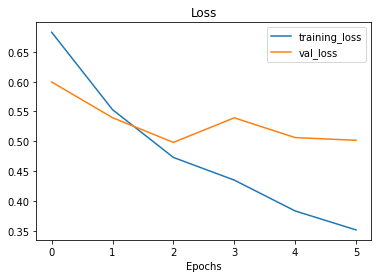

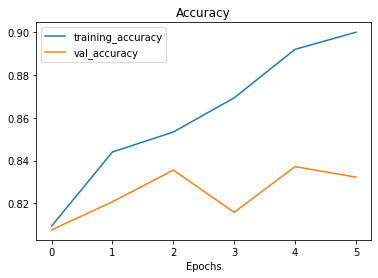

In [56]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit onec, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [65]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two Tensorflow History objects.
  """
  # Get original history measurments
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  #  Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")


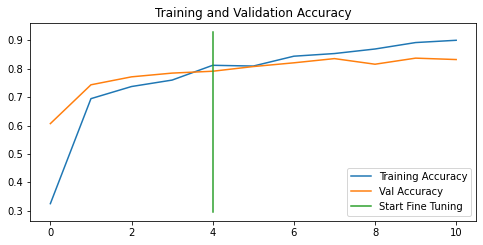

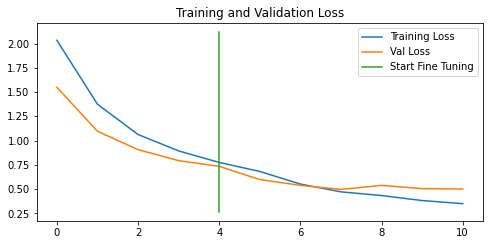

In [66]:
compare_histories(history_10_percent_data_aug, history_fine_10_percent_data_aug)

## Model 4: Fine-tuning and existing model on all of the data

In [67]:
# Download and unzip 10 classes  of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-10-19 15:19:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   125MB/s    in 4.0s    

2021-10-19 15:20:02 (122 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [68]:
# Setup Training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [69]:
# How many images are we working with now
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 

In [71]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


THe test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [72]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.4822 - accuracy: 0.8336


[0.48222386837005615, 0.8335999846458435]

In [74]:
results_fine_tune_10_percent

[0.48222386837005615, 0.8335999846458435]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [75]:
# Load weights from checkpoint, that way we can fine-tune from the
# same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [76]:
# Let's evaluate model 2
model_2.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.6939 - accuracy: 0.8088


[0.6938950419425964, 0.8087999820709229]

In [77]:
# Check if model 2 has reverted back to feature extraction results
results_10_percent_data_aug

[0.6938950419425964, 0.8087999820709229]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base_model unfrozen (model_3).
3. Saved the results and training log each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).

In [78]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [79]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer, in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [80]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [82]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20211019-154633
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 68s 258ms/step - loss: 0.7225 - accuracy: 0.7689 - val_loss: 0.3517 - val_accuracy: 0.8799
Epoch 6/10
235/235 [==============================] - 81s 341ms/step - loss: 0.5845 - accuracy: 0.8095 - val_loss: 0.3355 - val_accuracy: 0.8799
Epoch 7/10
235/235 [==============================] - 75s 316ms/step - loss: 0.5113 - accuracy: 0.8365 - val_loss: 0.3226 - val_accuracy: 0.8898
Epoch 8/10
235/235 [==============================] - 72s 303ms/step - loss: 0.4820 - accuracy: 0.8451 - val_loss: 0.3209 - val_accuracy: 0.9013
Epoch 9/10
235/235 [==============================] - 64s 268ms/step - loss: 0.4396 - accuracy: 0.8585 - val_loss: 0.3043 - val_accuracy: 0.9013
Epoch 10/10
235/235 [==============================] - 63s 263ms/step - loss: 0.4124 - accuracy: 0.8677 - val_loss: 0.2639 - val_accuracy: 0.9112


In [83]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 11s 134ms/step - loss: 0.3020 - accuracy: 0.9024


[0.3020468056201935, 0.902400016784668]

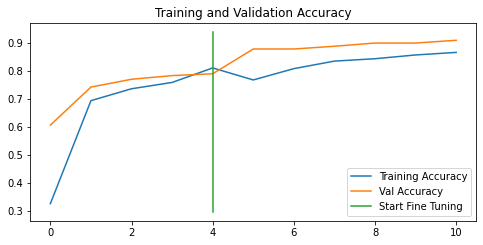

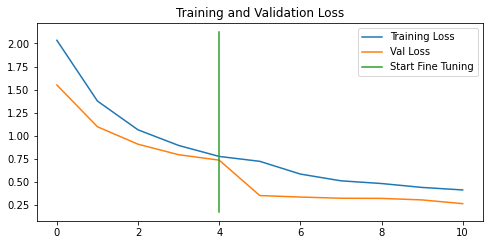

In [84]:
# How did fine-tuning go with more data?
compare_histories(original_history=history_10_percent_data_aug,
                  new_history=history_fine_10_classes_full,
                  initial_epochs=5)

That is some good looking plots and if we go for more epochs we might get more good results. The extra data really helped.

## Viewing our experiment data on tensorboard

> 🔑 **Note:** Anything you upload to Tensorboard.dev is going to be public. So if you have private data, do not upload.

In [ ]:
# View tensorborad logs of transfer learning modelling experiments (should ~4 models)
# Upload tensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning Experiments with Food101 Classes" \
--description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
--one_shot # exits the uploader once its finished uploading

In [87]:
# View all of your uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

2021-10-19 16:38:56.432534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 16:38:56.442094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 16:38:56.442770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/FMGGf42zTgiKJBAC9NQKZw/
	Name                 Transfer Learning Experiments with Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   FMGGf42zTgiKJBAC9NQKZw
	Created              2021-10-19 16:32:37 (

In [ ]:
# To delete an experiment
# !tensorboard dev delete --experiment_id